In [1]:
import string

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from wordcloud import STOPWORDS
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import emoji

from scipy import stats
import shap

from sklearn.metrics import roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from category_encoders import TargetEncoder

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('../input/nlp-getting-started/test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('\nTest Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB

Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


# 0. Constants

In [3]:
LOCATION_GROUPING_THRESHOLD = 3
IS_DISASTER = 1
NOT_DISASTER = 0
CORRELATION_THRESHOLD = 0.9
RANDOM_STATE = 42
VIF_CONSTANT = 1
MAX_ITER_BASELINE = 1000
CV = 5

# 1. EDA

## 1.1 Basic properties

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB


**Drop id column from dataframes. Save it separately for future submissions**

In [6]:
id_train = df_train['id']

id_test = df_test['id']

df_train.drop(columns = 'id',inplace = True)

df_test.drop(columns = 'id',inplace = True)

**Duplicates processing**  

In [7]:
df_train.duplicated().sum()

52

In [8]:
duplicates = df_train[df_train.duplicated(keep=False)]
duplicates

,keyword,location,text,target
40,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
48,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
106,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0
115,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0
118,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29,0
...,...,...,...,...
6392,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6434,suicide%20bombing,NaN,'Suicide bombing at [location named]...' #premonitions http://t.co/iIkSsJGBDn,1
6449,suicide%20bombing,NaN,'Suicide bombing at [location named]...' #premonitions http://t.co/iIkSsJGBDn,1
6652,terrorist,MAD as Hell,RT AbbsWinston: #Zionist #Terrorist kidnapped 15 #Palestinians in overnight terror on Palestinian Villages Û_ http://t.co/J5mKcbKcov,1


In [9]:
df_train = df_train.drop_duplicates()
df_train.duplicated().sum()

0

### **Statistical characteristics of data**

In [10]:
df_train.isna().sum()

keyword       61
location    2500
text           0
target         0
dtype: int64

In [11]:
df_test.isna().sum()

keyword       26
location    1105
text           0
dtype: int64

In [12]:
print('Percent of missing keyword in train data: {:.2f}%'.format(100 * df_train['keyword'].isna().mean()))
print('Percent of missing location in train data: {:.2f}%'.format(100 * df_train['location'].isna().mean()))
print('\nPercent of missing keyword in test data: {:.2f}%'.format(100 * df_test['keyword'].isna().mean()))
print('Percent of missing location in test data: {:.2f}%'.format(100 * df_test['location'].isna().mean()))

Percent of missing keyword in train data: 0.81%
Percent of missing location in train data: 33.06%

Percent of missing keyword in test data: 0.80%
Percent of missing location in test data: 33.86%


**We can conlcude, that missing values are distributed uniformly between df_train and df_test**

In [13]:
print('Number of unique keyword values in train data: {}'.format(df_train['keyword'].nunique()))
print('Number of unique location values in train data: {}'.format(df_train['location'].nunique()))
print('\nNumber of unique keyword values in test data: {}'.format(df_test['keyword'].nunique()))
print('Number of unique location values in test data: {}'.format(df_test['location'].nunique()))

Number of unique keyword values in train data: 221
Number of unique location values in train data: 3341

Number of unique keyword values in test data: 221
Number of unique location values in test data: 1602


In [14]:
for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [15]:
print('Number of disasters: {}'.format(df_train['target'].sum()))
print('Number of non-disasters: {}'.format(df_train['target'].count() - df_train['target'].sum()))

Number of disasters: 3239
Number of non-disasters: 4322


In [16]:
target_counts = df_train['target'].value_counts().reset_index()
target_counts.columns = ['target', 'count']

fig = px.pie(target_counts, 
             values='count', 
             names='target',
             title='Target Distribution',
             color_discrete_sequence=px.colors.sequential.Rainbow)

fig.update_traces(textposition='inside', 
                  textinfo='percent+label',
                  pull = [0.1, 0, 0, 0],
                  marker = dict(line = dict(color = '#000000', width = 1)))

fig.update_layout(
    title_font_size = 24,
    uniformtext_minsize = 12,
    uniformtext_mode = 'hide',
    height = 600,
    width = 600
)

fig.show()

In [17]:
keyword_counts = df_train['keyword'].value_counts()
keyword_counts

keyword
no_keyword               61
fatalities               45
deluge                   42
armageddon               42
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 222, dtype: int64

In [18]:
location_counts = df_train['location'].value_counts()
location_counts

location
no_location                     2500
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
everydaynigerian@gmail.com         1
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
Lincoln                            1
Name: count, Length: 3342, dtype: int64

In [19]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

df_sorted = df_train.sort_values(by='target_mean', ascending=False)

fig = px.histogram(df_sorted, 
                   y = 'keyword',
                   color = 'target',
                   orientation = 'h',
                   height = 3000,
                   width = 800,
                   title = 'Target Distribution in Keywords',
                   color_discrete_sequence = px.colors.qualitative.Pastel)

fig.update_layout(
    yaxis = dict(autorange = "reversed", tickfont = dict(size = 10)),
    legend = dict(x = 1, y = 1),
    xaxis = dict(tickfont = dict(size = 15))
)

df_train.drop(columns = ['target_mean'], inplace = True)

fig.show()

## 1.2 Feature Engineering

**Features below are further called METAFEATURES**

In [62]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import emoji
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

sid = SentimentIntensityAnalyzer()
STOPWORDS = set(ENGLISH_STOP_WORDS).union(set(stopwords.words('english')))

contractions = {
    'arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent',
    'hed', 'hell', 'hes', 'id', 'ill', 'im', 'isnt', 'itd', 'itll', 'ive',
    'mightnt', 'mustnt', 'neednt', 'shant', 'shed', 'shell', 'shes',
    'shouldnt', 'shouldve', 'thatll', 'theyd', 'theyll', 'theyre', 'theyve',
    'wasnt', 'wed', 'well', 'werent', 'weve', 'wont', 'wouldnt', 'youd',
    'youll', 'youre', 'youve'
}

STOPWORDS.update(contractions)

def add_word_count(df, text_column='text'):
    df['word_count'] = df[text_column].apply(lambda x: len(str(x).split()))
    return df

def add_unique_word_count(df, text_column='text'):
    df['unique_word_count'] = df[text_column].apply(lambda x: len(set(str(x).split())))
    return df

def add_stop_word_count(df, text_column='text'):
    df['stop_word_count'] = df[text_column].apply(
        lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    return df

def add_url_count(df, text_column='text'):
    df['url_count'] = df[text_column].apply(
        lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
    return df

def add_mean_word_length(df, text_column='text'):
    df['mean_word_length'] = df[text_column].apply(
        lambda x: np.mean([len(w) for w in str(x).split()]))
    return df

def add_char_count(df, text_column='text'):
    df['char_count'] = df[text_column].apply(lambda x: len(str(x)))
    return df

def add_punctuation_count(df, text_column='text'):
    df['punctuation_count'] = df[text_column].apply(
        lambda x: len([c for c in str(x) if c in string.punctuation]))
    return df

def add_hashtag_count(df, text_column='text'):
    df['hashtag_count'] = df[text_column].apply(lambda x: len([c for c in str(x) if c == '#']))
    return df

def add_mention_count(df, text_column='text'):
    df['mention_count'] = df[text_column].apply(lambda x: len([c for c in str(x) if c == '@']))
    return df

def add_excl_count(df, text_column='text'):
    df['excl_count'] = df[text_column].apply(lambda x: str(x).count('!'))
    return df

def add_vader_scores(df, text_column='text'):
    sentiments = df[text_column].apply(lambda x: sid.polarity_scores(str(x)))
    df['vader_neg'] = sentiments.apply(lambda x: x['neg'])
    df['vader_neu'] = sentiments.apply(lambda x: x['neu'])
    df['vader_pos'] = sentiments.apply(lambda x: x['pos'])
    df['vader_compound'] = sentiments.apply(lambda x: x['compound'])
    return df

def add_emoji_count(df, text_column='text'):
    df['emoji_count'] = df[text_column].apply(lambda x: emoji.emoji_count(str(x)))
    return df

def add_caps_count(df, text_column='text'):
    df['caps_count'] = df[text_column].apply(
        lambda x: len([w for w in str(x).split() if w.isupper() and len(w) > 1]))
    return df

def add_all_text_features(df, text_column='text'):
    df = add_word_count(df, text_column)
    df = add_unique_word_count(df, text_column)
    df = add_stop_word_count(df, text_column)
    df = add_url_count(df, text_column)
    df = add_mean_word_length(df, text_column)
    df = add_char_count(df, text_column)
    df = add_punctuation_count(df, text_column)
    df = add_hashtag_count(df, text_column)
    df = add_mention_count(df, text_column)
    df = add_excl_count(df, text_column)
    df = add_vader_scores(df, text_column)
    df = add_emoji_count(df, text_column)
    df = add_caps_count(df, text_column)
    
    return df

In [21]:
df_train = add_all_text_features(df_train)
df_test = add_all_text_features(df_test)

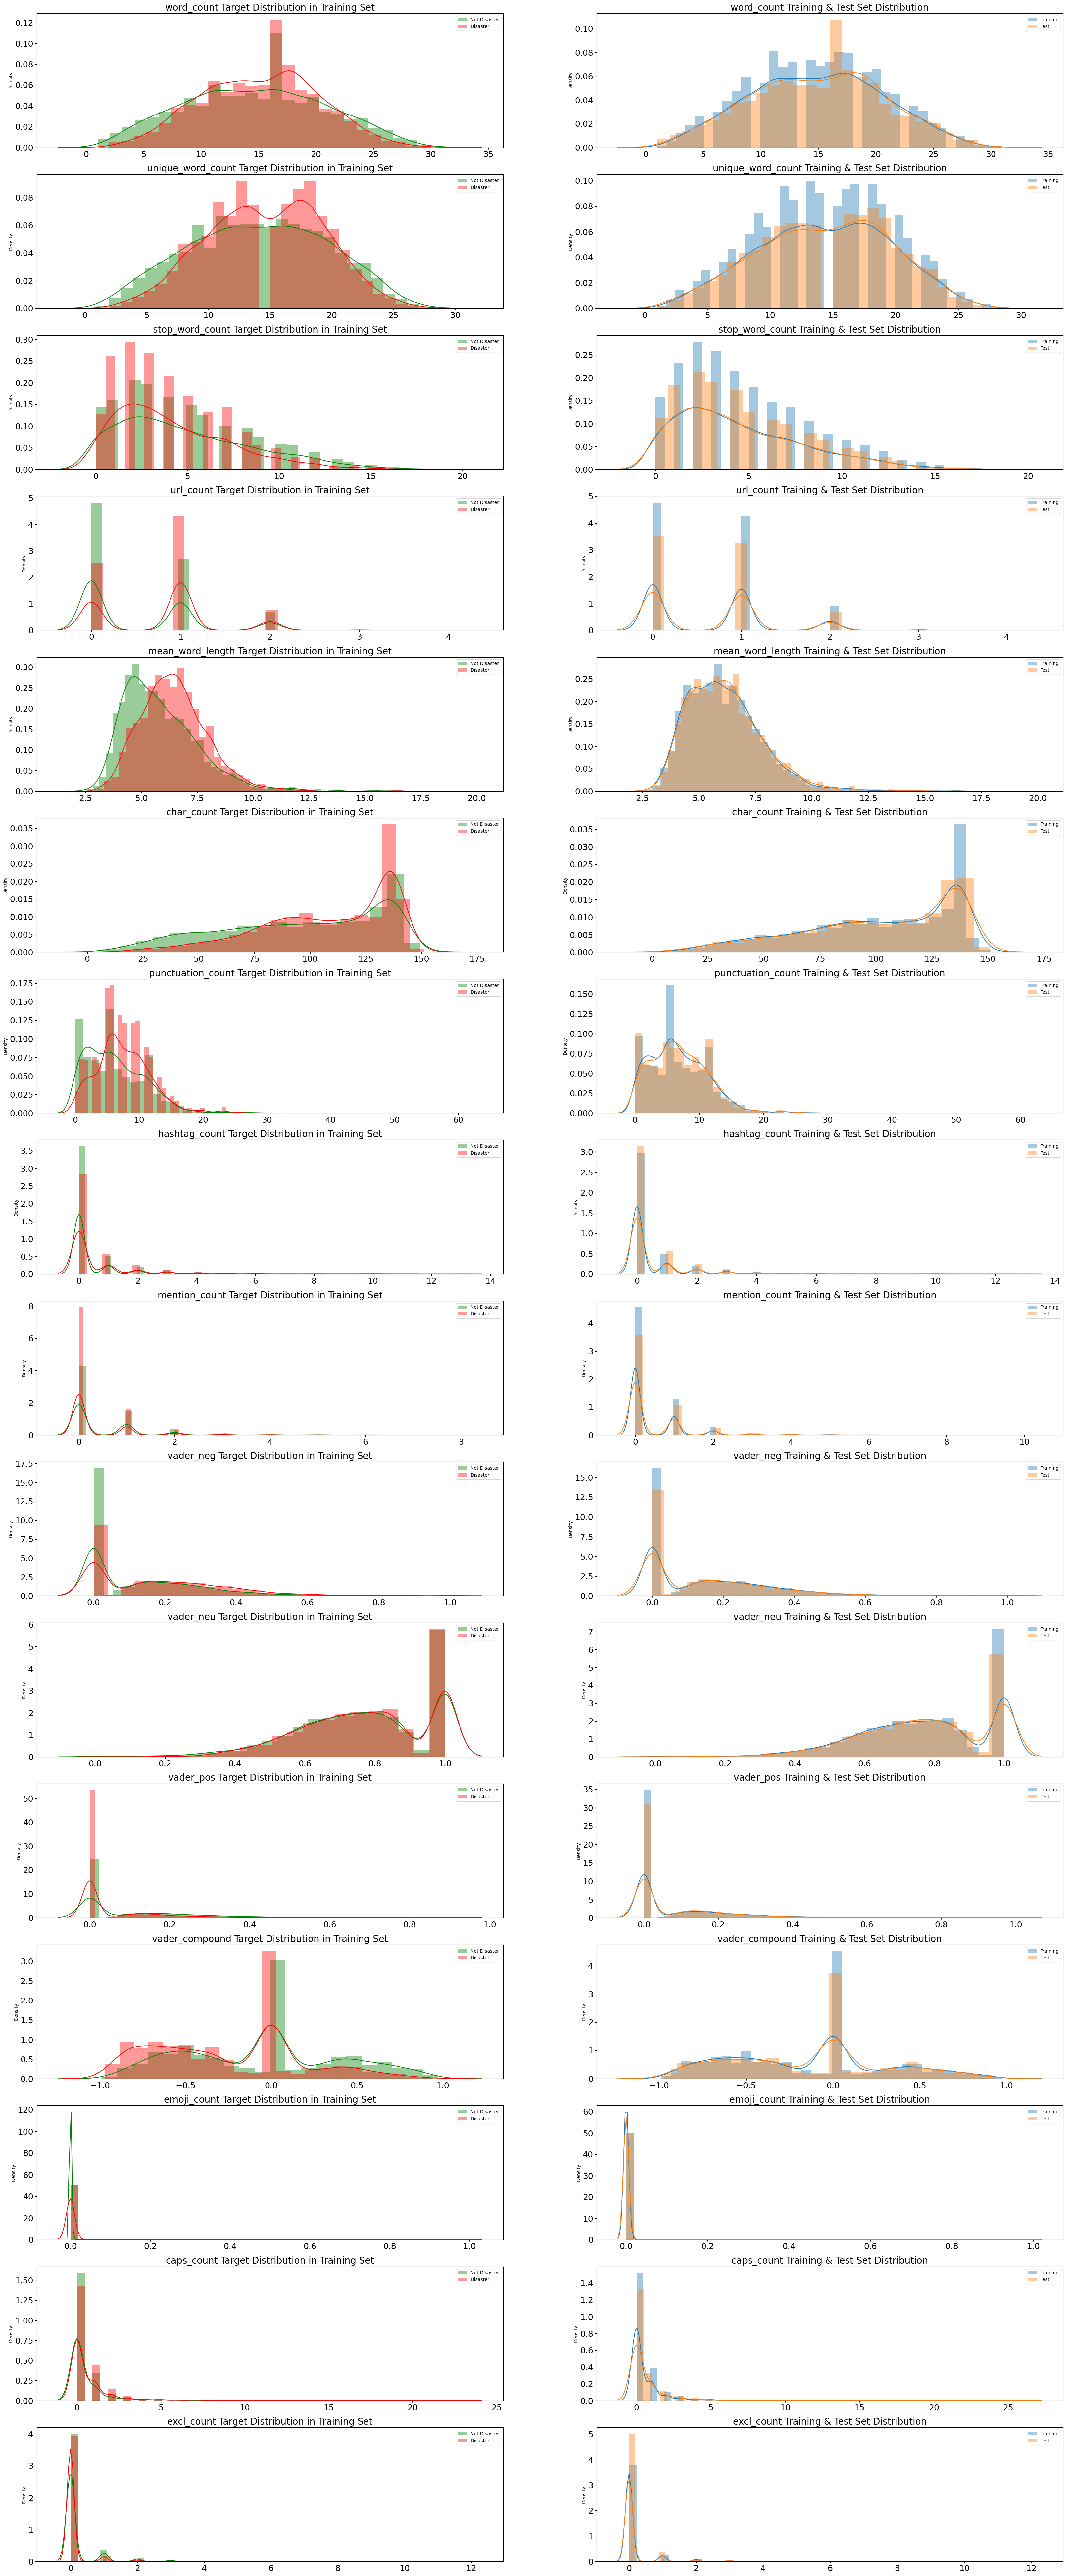

In [24]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 
                'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count',
                'mention_count', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
                'emoji_count', 'caps_count', 'excl_count']
DISASTER_TWEETS = df_train['target'] == IS_DISASTER

fig, axes = plt.subplots(ncols = 2, nrows = len(METAFEATURES), figsize = (40, 100), dpi = 100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=18)
        axes[i][j].tick_params(axis='y', labelsize=18)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=20)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=20)

plt.show()

## 1.3 Baseline with metafeatures

**Function below drops all features from train|test dataset except selected features**

In [25]:
def prepare_feature_subsets(df_train, df_test, all_features, selected_features, target_col='target'):

    df_train_subset = df_train.filter(items=all_features + [target_col]).copy()
    df_test_subset = df_test.filter(items=all_features + [target_col]).copy()
    
    cols_to_drop = list(set(all_features) - set(selected_features))
    
    for df in [df_train_subset, df_test_subset]:
        drop_cols = [col for col in cols_to_drop if col in df.columns]
        df.drop(columns = drop_cols, inplace = True)
    
    print(f"Train columns: {df_train_subset.columns.tolist()}")
    print(f"Test columns: {df_test_subset.columns.tolist()}")
    
    return df_train_subset, df_test_subset

**Function below makes a submission prediction of baseline model for Kaggle**

In [26]:
def baseline_model_submission(df_train, df_test, features, model_params=None, save_path=None):
    if model_params is None:
        model_params = {'random_state': RANDOM_STATE, 'verbose': False}
    
    X_train = df_train[features]
    y_train = df_train['target']

    X_test = df_test[features]
    
    model = CatBoostClassifier(**model_params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    submission = pd.DataFrame({
        'id': id_test,
        'target': y_pred
    })
    
    if save_path is not None:
        submission.to_csv(save_path, index=False)
        print(f'Submission file saved to {save_path}')
    
    return submission

**Function below returns a baseline model cv-value of F1**

In [27]:
def nested_cv_model(df_train, features, param_grid=None, cv=5):

    scaler = StandardScaler()
    X = scaler.fit_transform(df_train[features])
    y = df_train['target']
    
    base_params = {
        'random_state': 42,
        'class_weight': 'balanced',
        'max_iter': 10000,
        'tol': 1e-4,
        'verbose': 0
    }
    
    param_grid = [
        {
            'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100]
        },
        {
            'solver': ['lbfgs'],
            'penalty': ['l2'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100]
        },
        {
            'solver': ['saga'],
            'penalty': ['l1', 'l2'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'l1_ratio': [None]
        },
        {
            'solver': ['saga'],
            'penalty': ['elasticnet'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'l1_ratio': [0, 0.3, 0.5, 0.7, 1]
        }
    ]
    
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    outer_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    model = LogisticRegression(**base_params)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        grid = GridSearchCV(
            estimator = model,
            param_grid = param_grid,
            cv = inner_cv,
            scoring = make_scorer(f1_score),
            n_jobs = -1,
            error_score = 'raise',
            refit = True
        )
        
        try:
            scores = cross_val_score(grid, X, y, cv = outer_cv, 
                                     scoring = make_scorer(f1_score)
                                    )
        except Exception as e:
            print(f"Error during cross-validation: {str(e)}")
            return None, None
    
    print(f'F1 scores: {scores.round(4)}')
    print(f'Mean F1: {np.mean(scores):.4f} ± {np.std(scores):.4f}')
    
    grid.fit(X, y)
    print(f"\nBest parameters: {grid.best_params_}")
    if hasattr(grid.best_estimator_, 'n_iter_'):
        print(f"Total iterations used: {grid.best_estimator_.n_iter_[0]}")
    
    return np.mean(scores), grid.best_estimator_

In [28]:
def baseline_model_cv(df_train, df_test, features, model_params=None, cv=CV):
    if model_params is None:
        model_params = {
            'random_state': RANDOM_STATE,
            'max_iter': MAX_ITER_BASELINE,
            'class_weight': 'balanced'
        }
    
    X_train = df_train[features]
    y_train = df_train['target']
    
    model = LogisticRegression(**model_params)
    
    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    f1_scorer = make_scorer(f1_score)
    cv_scores = cross_val_score(model, X_train, y_train, cv=stratified_cv, scoring=f1_scorer)
    
    mean_f1 = cv_scores.mean()
    std_f1 = cv_scores.std()

    print(f'F1 scores: {[f"{score:.4f}" for score in cv_scores]}')
    print(f'Mean F1: {mean_f1:.4f} ± {std_f1:.4f}')
    
    return mean_f1, std_f1

In [29]:
df_train_meta, df_test_meta = prepare_feature_subsets(
    df_train = df_train,
    df_test = df_test,
    all_features = METAFEATURES,
    selected_features = METAFEATURES
)

Train columns: ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'emoji_count', 'caps_count', 'excl_count', 'target']
Test columns: ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'emoji_count', 'caps_count', 'excl_count']


In [30]:
F1_all_meta = baseline_model_cv(
    df_train = df_train_meta,
    df_test = df_test_meta,
    features = METAFEATURES,
)

F1 scores: ['0.6359', '0.6275', '0.6614', '0.6372', '0.6222']
Mean F1: 0.6369 ± 0.0135


In [31]:
F1_all_meta = nested_cv_model(
    df_train = df_train_meta,
    features = METAFEATURES
)

F1 scores: [0.6354 0.6317 0.6667 0.6395 0.6231]
Mean F1: 0.6393 ± 0.0147

Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Total iterations used: 17


## 1.4 Feature selection with SHAP

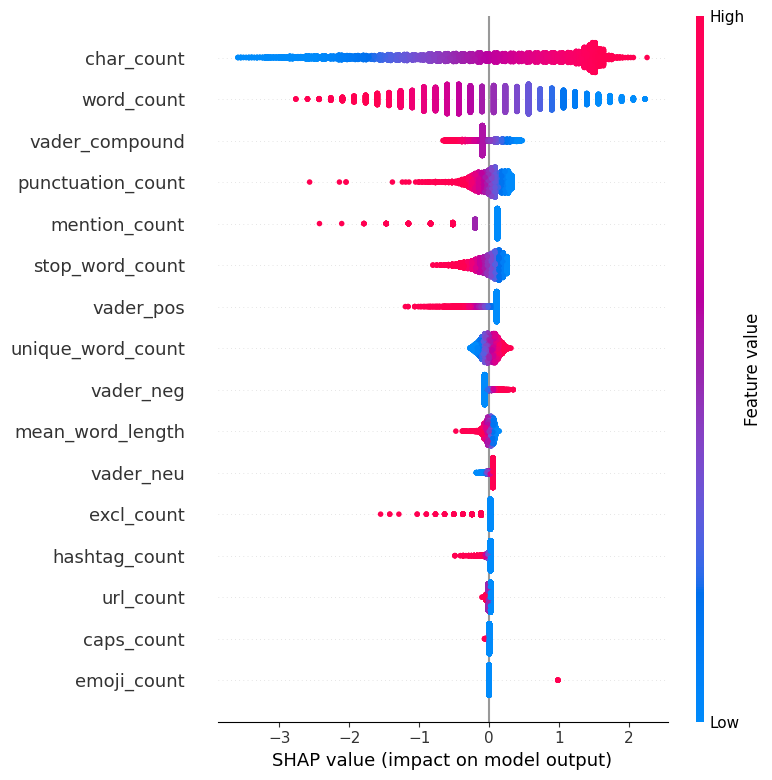

In [32]:
model = LogisticRegression(random_state = RANDOM_STATE,
                           max_iter = MAX_ITER_BASELINE,
                           class_weight = 'balanced'
                           )

X = df_train[METAFEATURES]
y = df_train['target']

model.fit(X, y)

shap.initjs()
explainer = shap.LinearExplainer(model, X)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, feature_names=METAFEATURES)

In [33]:
FEATURES_SHAP = [
    'mean_word_length', 'vader_neg', 'unique_word_count', 'vader_pos',
    'punctuation_count', 'vader_compound', 'mention_count', 'stop_word_count',
    'word_count', 'char_count'
]

In [34]:
df_train_shap, df_test_shap = prepare_feature_subsets(
    df_train = df_train,
    df_test = df_test,
    all_features = METAFEATURES,
    selected_features = FEATURES_SHAP
)

Train columns: ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length', 'char_count', 'punctuation_count', 'mention_count', 'vader_neg', 'vader_pos', 'vader_compound', 'target']
Test columns: ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length', 'char_count', 'punctuation_count', 'mention_count', 'vader_neg', 'vader_pos', 'vader_compound']


In [35]:
F1_shap = baseline_model_cv(
    df_train = df_train_shap,
    df_test = df_test_shap,
    features = FEATURES_SHAP,
)

F1 scores: ['0.6344', '0.6228', '0.6557', '0.6383', '0.6273']
Mean F1: 0.6357 ± 0.0114


In [36]:
F1_shap = nested_cv_model(
    df_train = df_train_shap,
    features = FEATURES_SHAP
)

F1 scores: [0.6348 0.6298 0.6591 0.6488 0.6263]
Mean F1: 0.6398 ± 0.0123

Best parameters: {'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
Total iterations used: 18


In [37]:
def filter_features(df, features_shap, meta_features, is_train=True):
    
    selected_features = set(meta_features) & set(features_shap)
    
    mandatory_cols = ['keyword', 'location', 'text']
    if is_train:
        mandatory_cols.append('target')
    selected_features.update(mandatory_cols)
    
    existing_cols = set(df.columns)
    final_cols = list(selected_features & existing_cols)
    
    return df[final_cols]

In [38]:
df_train = filter_features(
    df_train, 
    FEATURES_SHAP, 
    METAFEATURES, 
    is_train=True
)

df_test = filter_features(
    df_test, 
    FEATURES_SHAP, 
    METAFEATURES, 
    is_train=False
)

In [39]:
METAFEATURES = FEATURES_SHAP

In [40]:
print(METAFEATURES)
print(df_train.columns.tolist())
print(df_test.columns.tolist())

['mean_word_length', 'vader_neg', 'unique_word_count', 'vader_pos', 'punctuation_count', 'vader_compound', 'mention_count', 'stop_word_count', 'word_count', 'char_count']
['location', 'mean_word_length', 'word_count', 'vader_compound', 'char_count', 'keyword', 'text', 'stop_word_count', 'unique_word_count', 'target', 'vader_pos', 'punctuation_count', 'mention_count', 'vader_neg']
['location', 'mean_word_length', 'word_count', 'vader_compound', 'char_count', 'keyword', 'text', 'stop_word_count', 'unique_word_count', 'vader_pos', 'punctuation_count', 'mention_count', 'vader_neg']


# 2. Text processing

## 2.1 Full pipeline

In [41]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

def preprocess_location(df, threshold):
    if 'location' not in df.columns:
        df['location_grouped'] = 'other'
        return df
    
    df['location'] = df['location'].fillna('unknown')
    loc_counts = df['location'].value_counts()
    df['location_grouped'] = df['location'].apply(
        lambda x: x if pd.notna(x) and loc_counts.get(x, 0) > threshold else 'other'
    )
    return df.drop(columns=['location'], errors='ignore')

In [63]:
def build_full_pipeline():
    # location grouping
    preprocess_loc = FunctionTransformer(
        preprocess_location,
        kw_args = {'threshold': LOCATION_GROUPING_THRESHOLD},
        validate = False
    )

    # main ColumnTransformer
    preprocessor = ColumnTransformer([
        # text clean + tfidf
        ('text_tfidf',
         TfidfVectorizer(
           preprocessor = clean_text,
           max_features = 5000,
           ngram_range = (1,2),
           stop_words = list(STOPWORDS) 
         ),
         'text'
        ),

        # target‐encode keyword
        ('keyword_te',
         TargetEncoder(smoothing = 0.3),
         ['keyword']
        ),

        # target‐encode location_grouped
        ('loc_te',
         TargetEncoder(smoothing = 0.3),
         ['location_grouped']
        ),

        # passthrough metafeautres
        ('meta', 'passthrough', METAFEATURES),
    ], remainder = 'drop',
       sparse_threshold = 0.0
    )

    # full pipeline
    pipe = Pipeline([
        ('group_locs', preprocess_loc),
        ('encode_and_vectorize', preprocessor),
        ('clf',
         LogisticRegression(
             class_weight = 'balanced',
             solver = 'saga',
             max_iter = 3000,
             tol = 1e-4,
             C = 1.0,
             random_state = RANDOM_STATE,
             n_jobs = -1
         )
        ),
    ])

    return pipe

In [64]:
def evaluate_pipeline(df_train, target_col = 'target'):
    pipe = build_full_pipeline()
    X = df_train.drop(columns = [target_col])
    y = df_train[target_col]

    f1 = make_scorer(f1_score)
    scores = cross_val_score(pipe, X, y,
                             cv = CV,
                             scoring = f1,
                             n_jobs = -1
                             )
    print("F1 scores:", scores)
    print(f"Mean F1: {scores.mean():.4f}  Std: {scores.std():.4f}")
    return scores.mean()

In [65]:
mean_f1 = evaluate_pipeline(df_train)

F1 scores: [0.63730985 0.54232425 0.60912281 0.55737705 0.69414317]
Mean F1: 0.6081  Std: 0.0551


In [94]:
def build_tfidf_pipeline(text_col='text'):
    return Pipeline([
        ('extract', FunctionTransformer(lambda df: df[text_col], validate=False)),

        ('tfidf', TfidfVectorizer(
            preprocessor = clean_text,
            stop_words = list(STOPWORDS),
            ngram_range = (1,2),
            max_features = 5000
        )),

        ('clf', LogisticRegression(
            class_weight = 'balanced',
            solver = 'saga',
            max_iter = 3000,
            tol = 1e-4,
            C = 1.0,
            random_state = RANDOM_STATE,
            n_jobs = -1
        ))
    ])

In [95]:
def nested_cv_pipeline(df_train, target_col='target', cv=5):
    pipe = build_tfidf_pipeline(text_col='text')
    X = df_train.drop(columns=[target_col])
    y = df_train[target_col]

    param_grid = [
        {
            'clf__C': [0.1, 1, 10],
            'clf__penalty': ['l1', 'l2'],
            'clf__solver': ['liblinear'],
            'tfidf__max_features': [1000, 3000, 5000],
        },
        {
            'clf__C': [0.1, 1, 10],
            'clf__penalty': ['elasticnet'],
            'clf__solver': ['saga'],
            'clf__l1_ratio': [0.2, 0.5, 0.8],
            'tfidf__max_features': [1000, 3000, 5000],
        }
    ]

    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    outer_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    grid = GridSearchCV(
        estimator = pipe,
        param_grid = param_grid,
        cv = inner_cv,
        scoring = make_scorer(f1_score),
        n_jobs = 1,
        error_score = 'raise',
        verbose = 0
    )

    scores = cross_val_score(
        grid, X, y,
        cv = outer_cv,
        scoring = make_scorer(f1_score),
        n_jobs = 1
    )
    print(f'F1 scores: {scores.round(4)}')
    print(f'Mean F1: {scores.mean():.4f} ± {scores.std():.4f}')

    grid.fit(X, y)
    print("Best parameters:", grid.best_params_)

    return scores.mean(), grid.best_estimator_

In [96]:
mean_f1, best_pipeline = nested_cv_pipeline(df_train)

F1 scores: [0.7552 0.7556 0.749  0.7601 0.7754]
Mean F1: 0.7591 ± 0.0089
Best parameters: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__max_features': 5000}
